# Промежуточная аттестация 2

## Загрузка модулей

In [1]:
import psycopg2
from psycopg2 import Error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

## Подключение к базе данных и выполнение запросов

In [2]:
DB_PARAMS = {
    "dbname": "dvdrental",
    "user": "postgres",
    "password": "999999999",
    "host": "127.0.0.1",
    "port": "5432",
    "options": "-c client_encoding=utf8",
}


class SakilaDatabase:
    """Class for working with the Sakila database."""

    def __init__(self, db_params):
        self.db_params = db_params

    def execute_query(self, query):
        """Executes a SQL query and returns the result as a DataFrame."""
        try:
            with psycopg2.connect(**self.db_params) as conn:
                with conn.cursor() as cur:
                    cur.execute(query)
                    colnames = [desc[0] for desc in cur.description]
                    data = cur.fetchall()
            return pd.DataFrame(data, columns=colnames)
        except Error as e:
            print("An exception occurred while working with Postgresql", e)


db = SakilaDatabase(DB_PARAMS)

### Доля фильмов в каждой рейтинговой категории

  rating  film_count percentage
0  PG-13         223      22.00
1  NC-17         210      21.00
2      R         195      19.00
3     PG         194      19.00
4      G         178      17.00


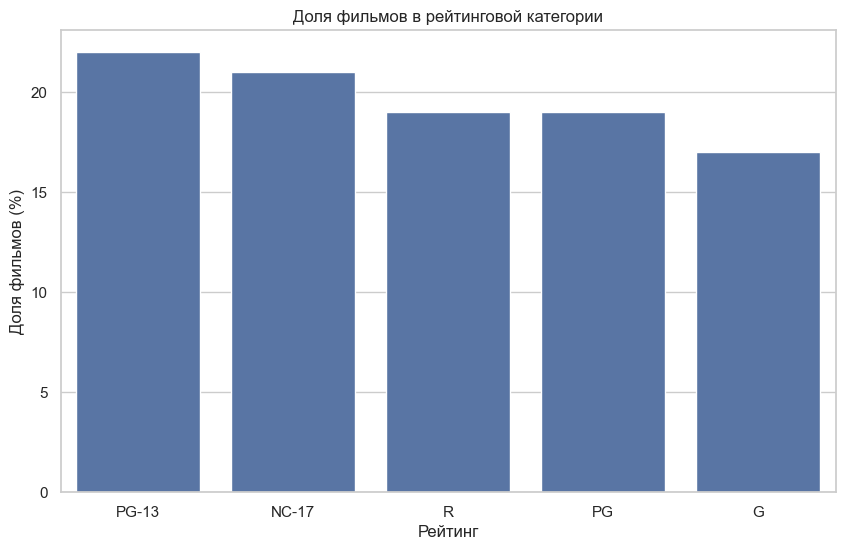

In [3]:
query = """
SELECT rating, COUNT(*) AS film_count,
       ROUND(100 * COUNT(*) / (SELECT COUNT(*) FROM film), 2) AS percentage
FROM film
GROUP BY rating
ORDER BY percentage DESC;
"""

df = db.execute_query(query)
df.to_csv("./rating_distribution.csv", index=False)
print(df.head())

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="rating", y="percentage")
plt.xlabel("Рейтинг")
plt.ylabel("Доля фильмов (%)")
plt.title("Доля фильмов в рейтинговой категории")
plt.show()

### Чаще всего арендуемые категории фильмов

    category  rental_count
0     Sports          1179
1  Animation          1166
2     Action          1112
3     Sci-Fi          1101
4     Family          1096


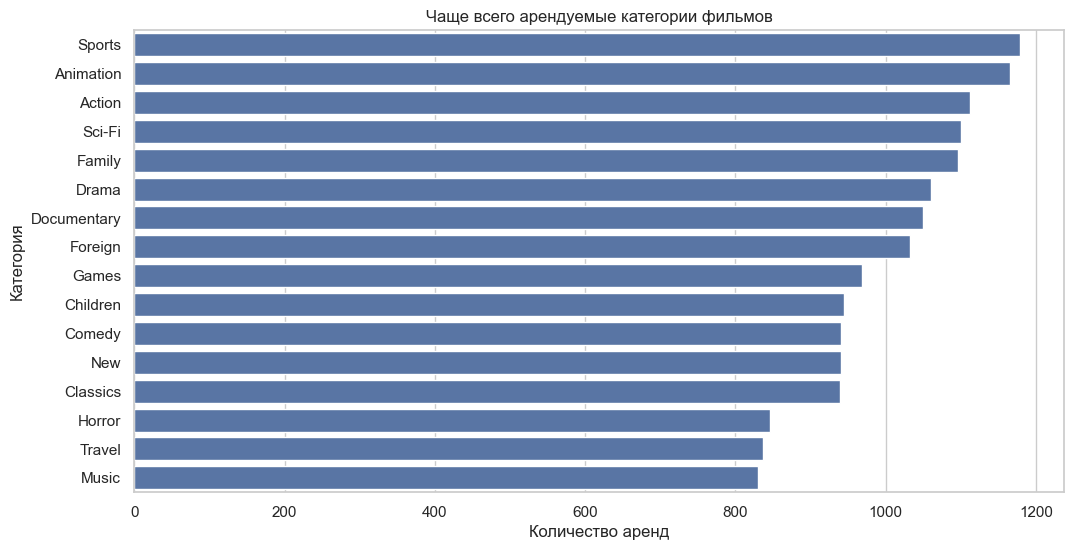

In [4]:
query = """
SELECT c.name AS category, COUNT(r.rental_id) AS rental_count
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY rental_count DESC;
"""

df = db.execute_query(query)
df.to_csv("./category_rentals.csv", index=False)
print(df.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="rental_count", y="category", orient="h")
plt.xlabel("Количество аренд")
plt.ylabel("Категория")
plt.title("Чаще всего арендуемые категории фильмов")
plt.show()

### Средняя продолжительность проката для каждой категории фильмов

  category avg_rental_duration
0   Travel                5.35
1    Music                5.24
2   Family                5.17
3  Foreign                5.11
4    Drama                5.08


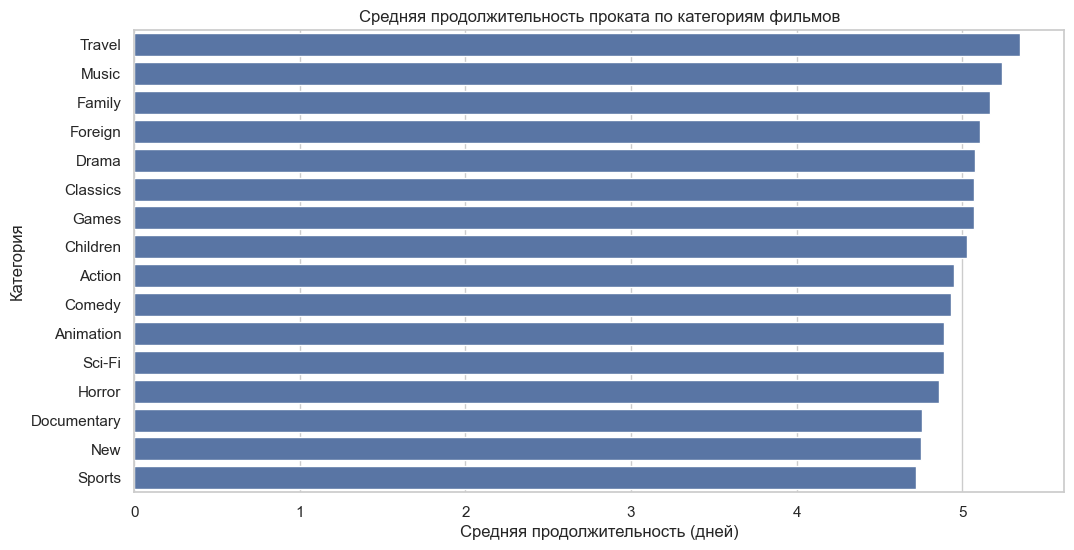

In [5]:
query = """
SELECT c.name AS category, ROUND(AVG(f.rental_duration), 2) AS avg_rental_duration
FROM film f
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY avg_rental_duration DESC;
"""

df = db.execute_query(query)
df.to_csv("./avg_rental_duration.csv", index=False)
print(df.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="avg_rental_duration", y="category", orient="h")
plt.xlabel("Средняя продолжительность (дней)")
plt.ylabel("Категория")
plt.title("Средняя продолжительность проката по категориям фильмов")
plt.show()

### Тенденции в ежемесячном доходе от проката за прошедший год

  month month_name  rental_count total_revenue
0     6       June          2015       8349.85
1     7       July          6713      28377.87
2     8     August          5686      24070.14


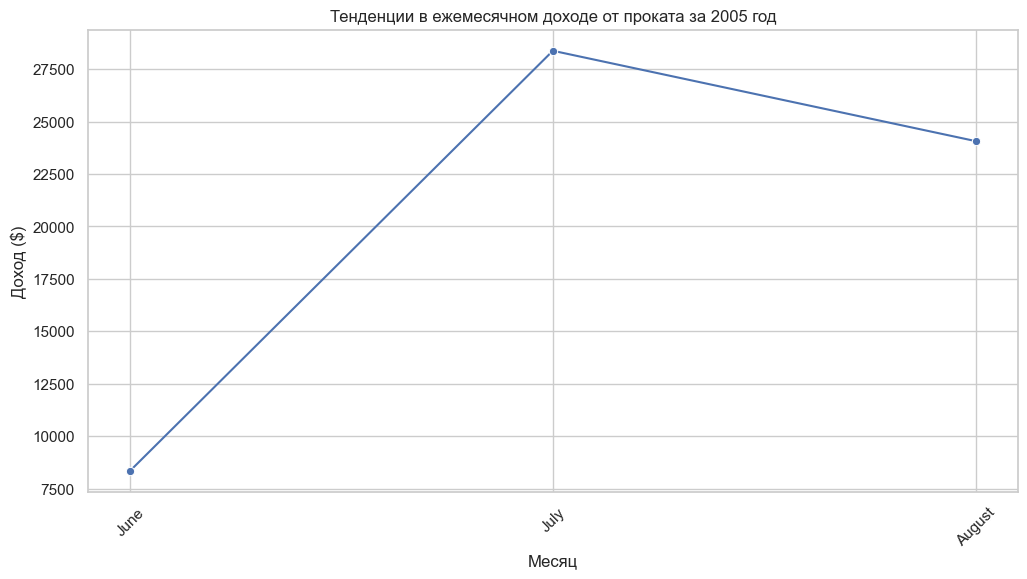

In [6]:
query = """
SELECT 
    EXTRACT(MONTH FROM r.rental_date) AS month,
    TO_CHAR(r.rental_date, 'FMMonth') AS month_name,
    COUNT(r.rental_id) AS rental_count,
    ROUND(SUM(p.amount), 2) AS total_revenue
FROM rental r
JOIN payment p ON r.rental_id = p.rental_id
WHERE EXTRACT(YEAR FROM r.rental_date) = 2005
GROUP BY month, month_name
ORDER BY month;
"""

df = db.execute_query(query)
df.to_csv("monthly_revenue.csv", index=False)
print(df)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="month_name", y="total_revenue", marker="o")
plt.xlabel("Месяц")
plt.ylabel("Доход ($)")
plt.title("Тенденции в ежемесячном доходе от проката за 2005 год")
plt.xticks(rotation=45)
plt.show()

### Сравнение продаж в разных магазинах

   store_id total_sales  total_units_sold
0         2    30683.13              7385
1         1    30628.91              7211


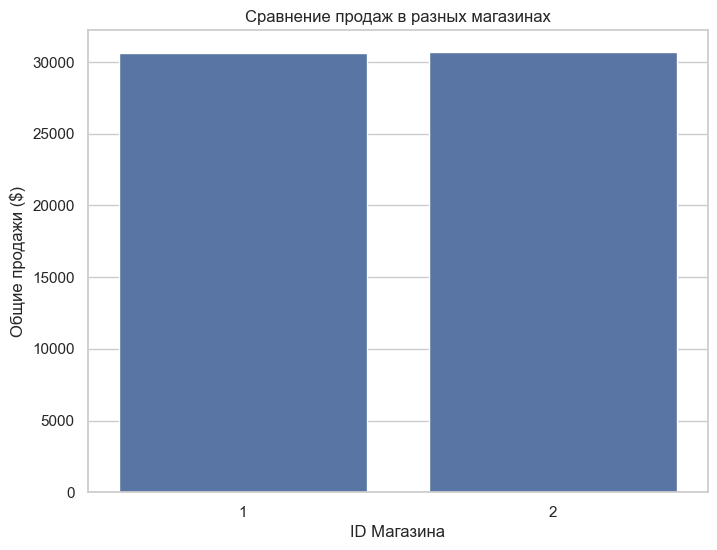

In [7]:
query = """
SELECT 
    s.store_id, 
    ROUND(SUM(p.amount), 2) AS total_sales,
    COUNT(p.payment_id) AS total_units_sold
FROM payment p
JOIN rental r ON p.rental_id = r.rental_id
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN store s ON i.store_id = s.store_id
GROUP BY s.store_id
ORDER BY total_sales DESC;
"""

df = db.execute_query(query)
df.to_csv("./store_sales.csv", index=False)
print(df)

plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="store_id", y="total_sales")
plt.xlabel("ID Магазина")
plt.ylabel("Общие продажи ($)")
plt.title("Сравнение продаж в разных магазинах")
plt.show()

### Средние затраты на замену фильмов по жанрам

   category avg_replacement_cost
0    Sci-Fi                21.15
1     Drama                21.09
2  Classics                21.01
3    Action                20.91
4    Sports                20.40


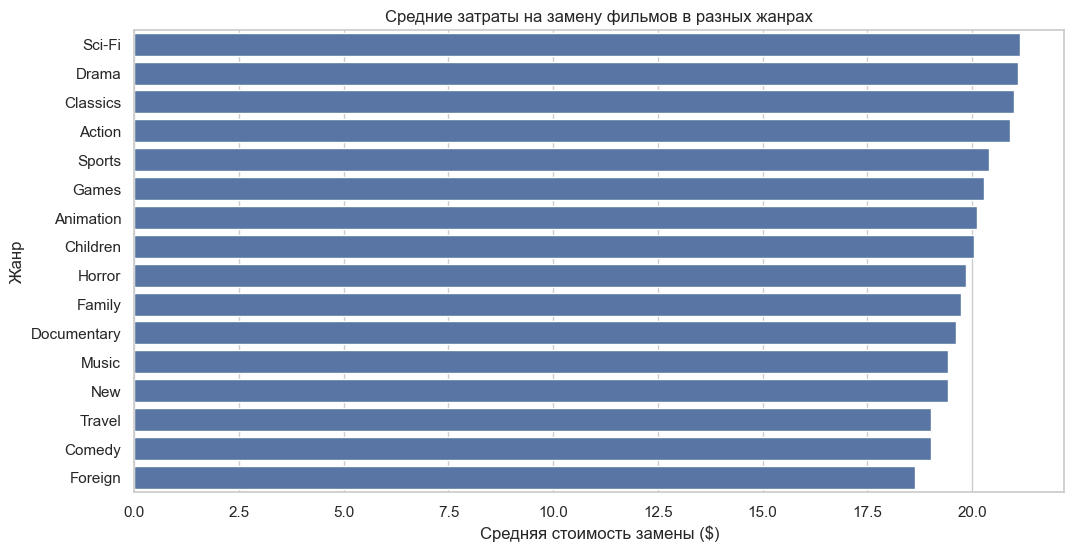

In [8]:
query = """
SELECT c.name AS category, ROUND(AVG(f.replacement_cost), 2) AS avg_replacement_cost
FROM film f
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY avg_replacement_cost DESC;
"""

df = db.execute_query(query)
df.to_csv("./replacement_cost.csv", index=False)
print(df.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="avg_replacement_cost", y="category", orient="h")
plt.xlabel("Средняя стоимость замены ($)")
plt.ylabel("Жанр")
plt.title("Средние затраты на замену фильмов в разных жанрах")
plt.show()

### Актеры, снимающиеся в разных жанрах фильмов

   actor_id      actor_name  genre_count
0       106   Groucho Dunst           16
1        13        Uma Wood           16
2       161     Harvey Hope           16
3        72   Sean Williams           16
4       107  Gina Degeneres           16


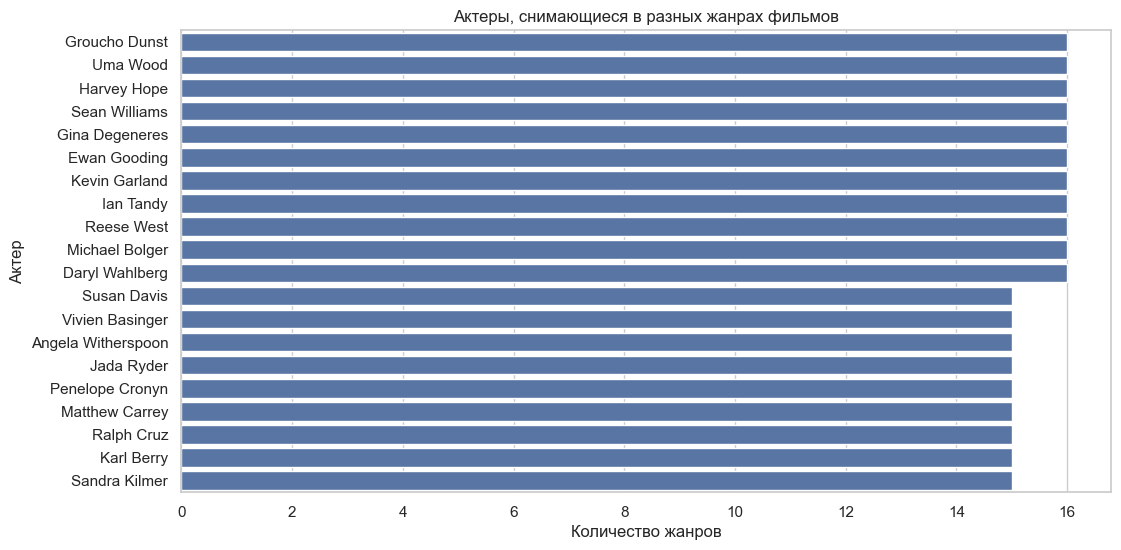

In [9]:
query = """
SELECT a.actor_id, a.first_name || ' ' || a.last_name AS actor_name, COUNT(DISTINCT c.category_id) AS genre_count
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
JOIN film f ON fa.film_id = f.film_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY a.actor_id, actor_name
ORDER BY genre_count DESC;
"""

df = db.execute_query(query)
df.to_csv("./diverse_actors.csv", index=False)
print(df.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=df.head(20), x="genre_count", y="actor_name", orient="h")
plt.xlabel("Количество жанров")
plt.ylabel("Актер")
plt.title("Актеры, снимающиеся в разных жанрах фильмов")
plt.show()

## Статистический анализ данных

### Получение объединенной таблицы

In [10]:
query = """
SELECT 
    r.rental_date,
    p.amount::real,
    c.first_name || ' ' || c.last_name AS customer_name,
    c.email,
    f.title AS film_title,
    f.release_year,
    f.rental_rate::real,
    f.length AS film_length,
    f.rating
FROM rental r
JOIN payment p ON r.rental_id = p.rental_id
JOIN customer c ON r.customer_id = c.customer_id
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id;
"""

df = db.execute_query(query)
df.to_csv("./combined_data.csv", index=False)

df.dtypes

rental_date      datetime64[ns]
amount                  float64
customer_name            object
email                    object
film_title               object
release_year              int64
rental_rate             float64
film_length               int64
rating                   object
dtype: object

### Анализ числовых переменных

In [11]:
numeric_columns = df.select_dtypes(include=["number"]).columns
numeric_analysis = pd.DataFrame(
    {
        "missing_ratio": df[numeric_columns].isnull().mean(),
        "min": df[numeric_columns].min(),
        "max": df[numeric_columns].max(),
        "mean": df[numeric_columns].mean().round(2),
        "median": df[numeric_columns].median(),
        "variance": df[numeric_columns].var().round(2),
        "quantile_0.1": df[numeric_columns].quantile(0.1),
        "quantile_0.9": df[numeric_columns].quantile(0.9),
        "quartile_1": df[numeric_columns].quantile(0.25),
        "quartile_3": df[numeric_columns].quantile(0.75),
    }
)

numeric_analysis.to_csv("./numeric_analysis.csv", index=False)
numeric_analysis

,missing_ratio,min,max,mean,median,variance,quantile_0.1,quantile_0.9,quartile_1,quartile_3
amount,0.0,0.00,11.99,4.20,3.99,5.61,0.99,6.99,2.99,4.99
release_year,0.0,2006.00,2006.00,2006.00,2006.00,0.00,2006.00,2006.00,2006.00,2006.00
rental_rate,0.0,0.99,4.99,2.94,2.99,2.72,0.99,4.99,0.99,4.99
film_length,0.0,46.00,185.00,114.95,113.00,1606.97,60.00,172.00,81.00,148.00


### Анализ категориальных переменных

In [12]:
categorical_columns = df.select_dtypes(include=["object", "datetime"]).columns
categorical_analysis = pd.DataFrame(
    {
        "missing_ratio": df[categorical_columns].isnull().mean(),
        "unique_count": df[categorical_columns].nunique(),
        "mode": df[categorical_columns].mode().iloc[0],
    }
)

categorical_analysis.to_csv("./categorical_analysis.csv", index=False)
categorical_analysis

,missing_ratio,unique_count,mode
rental_date,0.0,14364,2006-02-14 15:16:03
customer_name,0.0,599,Eleanor Hunt
email,0.0,599,eleanor.hunt@sakilacustomer.org
film_title,0.0,958,Juggler Hardly
rating,0.0,5,PG-13
